## Import Library and Funcitons

In [1]:
import datetime
import logging
import numpy as np
import pandas as pd
import sklearn.metrics
import xgboost
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from ds_utils import e4
from ds_utils import aggregators
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFolddef prepare_data(pir, part, agg, time_windows):
    """Prepare data for predictions on the interested emotion.The returned dataframe will include all six emotions
        The function use aggregate function in ds_util
    Args:
        pir (int): person in recovery id number
        part (int): part of the file to load
        agg (Union[Dict[str, Callable], Iterable[Dict[str, Callable]]]): a dict of functions to apply to each column, 
                with keys as column names, or a list of dicts of functions separated for each window
        time_windows (Iterable[str]): a list of a window sizes in units that can be used for resample
    Returns: 
        pd.DataFrame: data with all six emotions ready for the xgboost model (and function XGBRegressorForSurveyFast)
    """
    emotion_list = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad']
    data = e4.read(pir, part=part, base_path='./data').add_craving_onset(1, 0, column_name='craving_onset')
    status = pd.read_parquet(f'./data/pir{pir}_status.pq', engine='auto')

    for emotion in emotion_list:
        status = status[status[emotion].first_valid_index():status[emotion].last_valid_index()]
    data = data.aggregate(500, agg, time_windows, sample_column='craving_onset')

    df = data.join(status, how='outer').sort_index()
    drop_list=['hash', 'is_craving', 'report_offset_hrs','id', 'duration_participation_s','craving_freq', 
               'need_help', 'support', 'report', 'cravings_today']
    df= df.drop(drop_list,axis=1)
    df = df[df['bvp'].first_valid_index():df['bvp'].last_valid_index()]

    for emotion in emotion_list:
        df = df[df[emotion].first_valid_index():df[emotion].last_valid_index()]

    for emotion in emotion_list:
        df[emotion] = df[emotion].ffill()

    df=df.dropna()
    
    return df

from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import ds_utils
import ds_utils.e4
from ds_utils.training import support

In [2]:
def mxdiff(arr):
    return np.max(np.diff(arr))
def prepare_data(pir, part, agg, time_windows):
    """Prepare data for predictions on the interested emotion.The returned dataframe will include all six emotions
        The function use aggregate function in ds_util
    Args:
        pir (int): person in recovery id number
        part (int): part of the file to load
        agg (Union[Dict[str, Callable], Iterable[Dict[str, Callable]]]): a dict of functions to apply to each column, 
                with keys as column names, or a list of dicts of functions separated for each window
        time_windows (Iterable[str]): a list of a window sizes in units that can be used for resample
    Returns: 
        pd.DataFrame: data with all six emotions ready for the xgboost model (and function XGBRegressorForSurveyFast)
    """
    emotion_list = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad']
    data = e4.read(pir, part=part, base_path='./data').add_craving_onset(1, 0, column_name='craving_onset')
    status = pd.read_parquet(f'./data/pir{pir}_status.pq', engine='auto')

    for emotion in emotion_list:
        status = status[status[emotion].first_valid_index():status[emotion].last_valid_index()]
    data = data.aggregate(500, agg, time_windows, sample_column='craving_onset')

    df = data.join(status, how='outer').sort_index()
    drop_list=['hash', 'is_craving', 'report_offset_hrs','id', 'duration_participation_s','craving_freq', 
               'need_help', 'support', 'report', 'cravings_today']
    df= df.drop(drop_list,axis=1)
    df = df[df['bvp'].first_valid_index():df['bvp'].last_valid_index()]

    for emotion in emotion_list:
        df = df[df[emotion].first_valid_index():df[emotion].last_valid_index()]

    for emotion in emotion_list:
        df[emotion] = df[emotion].ffill()

    df=df.dropna()
    
    return df

def training_to_xgb(data) -> xgboost.XGBClassifier:
    """Pass a list of dataframes to be used as training data for an XGBoost classifier
    Args:
        dfs (list[pd.DataFrame]): a list of aggregated data dataframes
    Returns:
        xgboost.XGBClassifier: a trained classifier
    
    """
    X = data.drop(columns=['craving_onset']).values
    Y = data['craving_onset'].map({True: 1, False: 0}).values

    model = xgboost.XGBClassifier(max_depth=9, subsample=0.9, colsample_bytree=0.3, objective='binary:logistic', n_estimators=100, learning_rate=0.15)
    model.fit(X, Y)
    
    return model


def test_xgb(df: pd.DataFrame, model: xgboost.XGBClassifier) -> np.ndarray:
    """Make predictions from a trained xgboost model on aggregated data
    Args:
        df (pd.DataFrame): test dataframe
        model (xgboost.XGBClassifier): trained model
    Returns:
        np.ndarray: the predicted values
    
    """
    X = df.drop(columns=['craving_onset']).values
    Y = df['craving_onset'].map({True: 1, False: 0}).values

    Y_pred = model.predict(X)
    predictions = [round(value) for value in Y_pred]
    accuracy = sklearn.metrics.accuracy_score(Y, Y_pred)
    precision = precision_score(Y, Y_pred, average='macro')
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Precision: %.2f%%" % (precision * 100.0))
    print(sklearn.metrics.confusion_matrix(Y, Y_pred))
    return Y_pred

def prepare_data_resample(pir, part):
    """Prepare data for predictions on the interested emotion.The returned dataframe will include all six emotions
        The function use aggregate function in ds_util
    Args:
        pir (int): person in recovery id number
        part (int): part of the file to load
        time_windows (Iterable[str]): a list of a window sizes in units that can be used for resample
    Returns: 
        pd.DataFrame: data with all six emotions ready for the xgboost model (and function XGBRegressorForSurveyFast)
    """
    emotion_list = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad']
    data = e4.read(pir, part=part, base_path='./data').add_craving_onset(2, 0, column_name='craving_onset')
    data = data.df.resample('1 s').mean()
    data = support.clean_nan_reference_column(data, 'bvp')
    status = pd.read_parquet(f'./data/pir{pir}_status.pq', engine='auto')

    for emotion in emotion_list:
        status = status[status[emotion].first_valid_index():status[emotion].last_valid_index()]
        
    means = data.resample('40 min').mean().add_suffix('_mean')
    stds = data.resample('40 min').std().add_suffix('_std')
    firsts = data.resample('40 min').last().add_suffix('_raw')
    out = firsts.join(means)
    data = out.join(stds)
    data = data.dropna()

    df = data.join(status, how='outer').sort_index()
    drop_list=['hash', 'is_craving', 'report_offset_hrs','id', 'duration_participation_s','craving_freq', 
               'need_help', 'support', 'report', 'cravings_today', 'craving_onset_mean', 'craving_onset_std']
    df= df.drop(drop_list,axis=1)

    for emotion in emotion_list:
        df = df[df[emotion].first_valid_index():df[emotion].last_valid_index()]

    for emotion in emotion_list:
        df[emotion] = df[emotion].ffill()

    df=df.dropna()
    
    return df

def XGBRegressorForSurveyFast (df, test, emotion, learning_rate = 0.15, max_depth = 9, colsample_bytree = 0.3,
                           subsample = 0.9):
    """predict the pir's emotions on a scale from 1 to 10  
    
    Args: 
        df (pd.DataFrame): the data set we need for the training and test data
        emotion (str): the emotion we are going to predict
        learning_rate (float): learning rate of XGB model, range [0, 1]. Defaults to 0.1
        max_depth (int): maximum depth of tree. Defaults to 5
        colsample_bytree (float): fraction of columns to be randomly sampled for each tree. Defaults to 0.3
        subsample (float): fraction of observations to be randomly sampled for each tree. Defaults to 0.8
    Return:
        xgboost.XGBRegressor: a trained regressor to predict on emotions
    """  
    
    # delete uneccessary columns
    emotionList = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad'] 
    emotionList.remove(emotion)
    dropList = emotionList + ['craving_onset']
    df = df.drop(dropList, axis=1)
    test = test.drop(dropList, axis=1)

     # get the name of columns for features
    new_cols = [col for col in df.columns if col != emotion] + [emotion]
    df = df[new_cols]
    test = test[new_cols]
    feature_columns = new_cols[:-1]

    # Isolate the x and y variables
    y = df.iloc[:, -1].values
    X = df.iloc[:, :-1].values
    
    test_y = test.iloc[:, -1].values
    test_X = test.iloc[:, :-1].values   
    
    finalModel = xgb.XGBRegressor(objective="reg:squarederror", learning_rate = learning_rate, max_depth = max_depth,
                                  colsample_bytree = colsample_bytree, subsample = subsample, n_estimators=100,random_state=123)
    finalModel.fit(X, y)
    
    # Predictions on test dataset
    preds = finalModel.predict(test_X)
    
    # plot pred and pred-actual
    fig, ax = plt.subplots(3, 1, figsize=(12,12))
    ax[0].hist(preds, bins = 50)
    ax[1].hist(test_y, bins = 50)
    ax[2].hist(preds - test_y, bins = 50)
    ax[0].set_title('pred')
    ax[1].set_title('actual')
    ax[2].set_title('pred - actual')

    plt.show()
    
    # show results
    rmse = np.sqrt(mean_squared_error(test_y, preds))
    print("RMSE: %f" % (rmse))
    
    
    # plot feature importances
    xgb.plot_importance(finalModel, max_num_features = 10)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    
    # plot true val vs. predictions
    true_val = test[emotion].values
    plt.plot(true_val)
    plt.plot(preds)
    plt.title("true val vs. predictions")
    plt.show()
    return finalModel

def df_with_emotion(df, model, emotion):
    """produce a new dataframe with predicted emotion attached to it
    
    Args: 
        df (pd.DataFrame): can be the same data used for the emotion prediction
        model (xgboost.XGBRegressor): used to produce prediction on the emotion
        emotion (str) : the emotion we are interested in
    Return:
        pd.DataFrame: a dataframe with the interested emotion attached
    """
    emotionList = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad']
    dropList = emotionList + ['craving_onset'] + ['pred_relaxed', 'pred_happy', 'pred_stressed', 'pred_tired', 'pred_anxious','pred_sad']
    df_X = df.copy().drop(dropList, axis=1, errors='ignore')
    df[f"pred_{emotion}"] = model.predict(df_X.values)
    df = df.drop(emotionList, axis=1, errors='ignore')
    return df

def classify(train, test):
    X = train.drop(columns=['craving_onset']).values
    Y = train['craving_onset'].values
    negs = np.arange(len(Y))[Y == 0]
    use_Y = (Y > 0)
    use_Y[np.random.choice(negs, int(1.5*sum(Y)), replace=False)] = True
    X = X[use_Y, :]
    Y = Y[use_Y]
    model = xgboost.XGBClassifier(max_depth=9, subsample=0.9, colsample_bytree=0.3, objective='binary:logistic', n_estimators=100, learning_rate=0.15)
    model.fit(X, Y, eval_metric=["error", "logloss"])
    X_test = test.drop(columns=['craving_onset']).values
    Y_test = test['craving_onset'].values
    y_pred = model.predict(X_test)
    best_preds = [round(value) for value in y_pred]
    precision = sklearn.metrics.precision_score(Y_test, best_preds, average='macro')
    accuracy = sklearn.metrics.accuracy_score(Y_test, best_preds)
    print(precision, accuracy)
    print(sklearn.metrics.confusion_matrix(Y_test, best_preds))
    return model

def classify(train, test):
    X = train.drop(columns=['craving_onset']).values
    Y = train['craving_onset'].map({True: 1, False: 0}).values
    negs = np.arange(len(Y))[Y == 0]
    use_Y = (Y > 0)
    use_Y[np.random.choice(negs, int(1.5*sum(Y)))] = True
    X = X[use_Y, :]
    Y = Y[use_Y]
    model = xgboost.XGBClassifier(max_depth=9, subsample=0.9, colsample_bytree=0.3, objective='binary:logistic', n_estimators=100, learning_rate=0.15)
    model.fit(X, Y, eval_metric=["error", "logloss"])
    X_test = test.drop(columns=['craving_onset']).values
    Y_test = test['craving_onset'].map({True: 1, False: 0}).values
    y_pred = model.predict(X_test)
    best_preds = [round(value) for value in y_pred]
    precision = sklearn.metrics.precision_score(Y_test, best_preds, average='macro')
    accuracy = sklearn.metrics.accuracy_score(Y_test, best_preds)
    print(precision, accuracy)
    print(sklearn.metrics.confusion_matrix(Y_test, best_preds))
    return model

## Prepare data

In [3]:
agg = {
    'acc_x': [aggregators.std, mxdiff],
    'acc_y': [aggregators.std, mxdiff],
    'acc_z': [aggregators.std, mxdiff],
    'heartrate': [aggregators.mean, aggregators.std, aggregators.agg_linear_trend],
    'conductance': [aggregators.mean, aggregators.std],
    'temperature': [aggregators.mean, aggregators.std],
    'bvp': [aggregators.mean, aggregators.std]
    }

time_windows = ['1 min', '1 h'] 


df1 = prepare_data(89, 1, agg, time_windows)
df1.head()

ts datetime64[ns]
1 min
ts datetime64[ns]
1 h
ts datetime64[ns]


,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,craving_onset,acc_x_1min__std,acc_x_1min__mxdiff,...,temperature_1h__mean,temperature_1h__std,bvp_1h__mean,bvp_1h__std,relaxed,happy,stressed,tired,anxious,sad
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-28 23:04:15.156250,-48.0,-6.0,26.0,55.300000,0.157604,90.82,33.79,False,13.081328,78.0,...,32.172899,1.270200,-0.861997,206.661256,6.0,6.0,7.0,7.0,7.0,5.0
2020-01-29 01:01:44.812500,26.0,-47.0,40.0,-15.215000,0.098662,90.10,33.55,False,27.420038,140.0,...,33.290916,0.689375,-0.344599,193.783685,6.0,6.0,7.0,7.0,7.0,5.0
2020-01-29 01:39:24.312500,-3.0,-63.0,7.0,-14.425000,0.023064,113.83,21.59,False,0.091073,2.0,...,30.684469,4.935246,-1.583329,197.336529,6.0,6.0,7.0,7.0,7.0,5.0
2020-01-29 01:58:46.500000,-3.0,-63.0,7.0,0.643333,0.016657,101.10,17.96,False,0.050965,1.0,...,27.716593,6.735566,-1.368394,172.377745,6.0,6.0,7.0,7.0,7.0,5.0
2020-01-29 04:28:55.406250,28.0,-32.0,46.0,-80.275000,2.544516,90.07,32.47,False,13.916888,38.0,...,32.386633,0.361547,-0.164057,138.679206,6.0,6.0,7.0,7.0,7.0,5.0


In [4]:
df2 = prepare_data(89, 2, agg, time_windows)
df3 = prepare_data( 89, 3, agg, time_windows)
test = prepare_data(89, 4, agg, time_windows)

ts datetime64[ns]
1 min
ts datetime64[ns]
1 h
ts datetime64[ns]
ts datetime64[ns]
1 min
ts datetime64[ns]
1 h
ts datetime64[ns]
ts datetime64[ns]
1 min
ts datetime64[ns]
1 h
ts datetime64[ns]


## Prediction on emotions

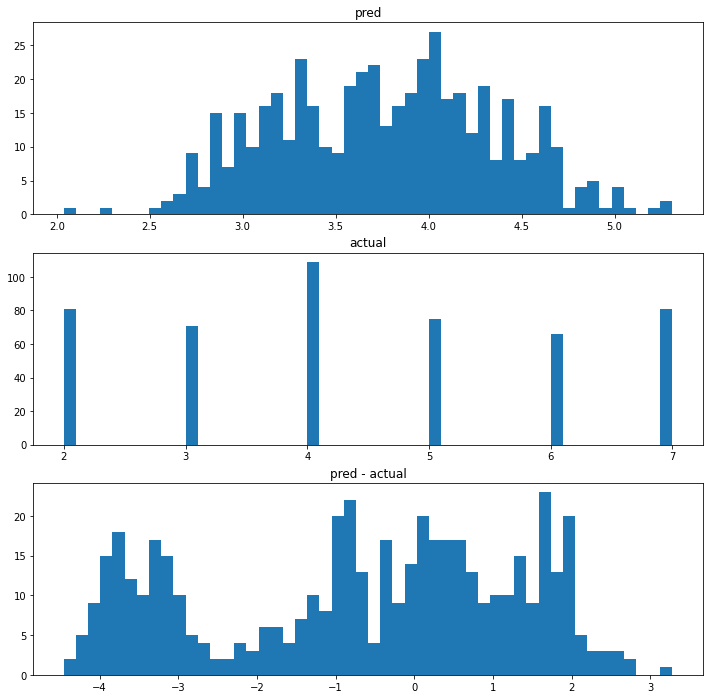

RMSE: 2.081622


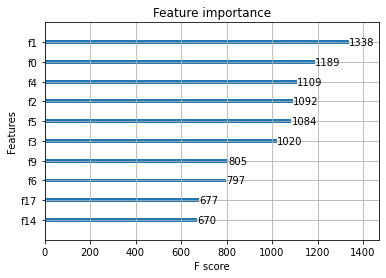

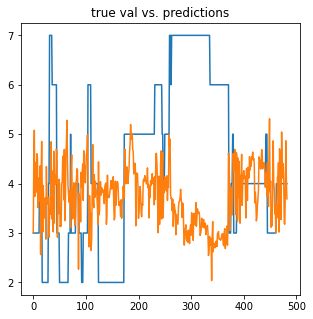

In [5]:
train = pd.concat([df1, df2, df3])
model_emotion_stressed = XGBRegressorForSurveyFast(train, test, "stressed")

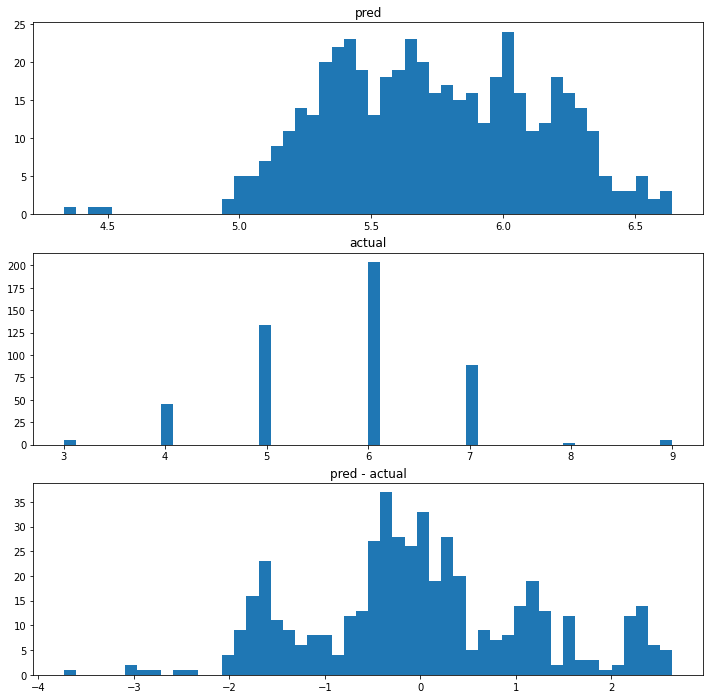

RMSE: 1.176746


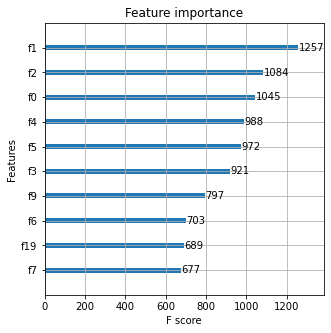

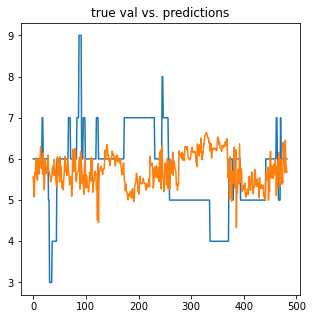

In [6]:
model_emotion_happy = XGBRegressorForSurveyFast(train, test, "happy")

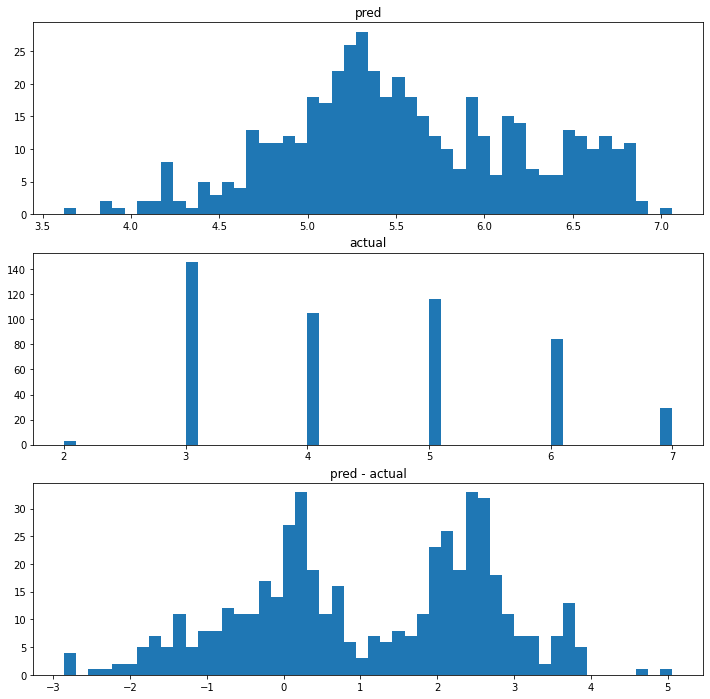

RMSE: 1.921498


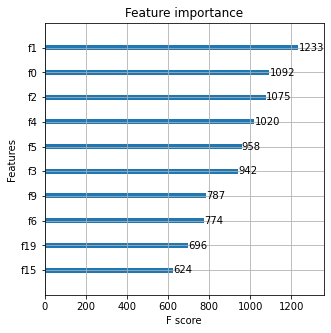

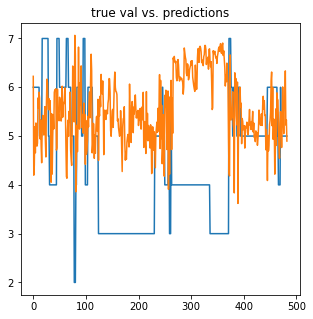

In [7]:
model_emotion_relaxed = XGBRegressorForSurveyFast(train, test, "relaxed")

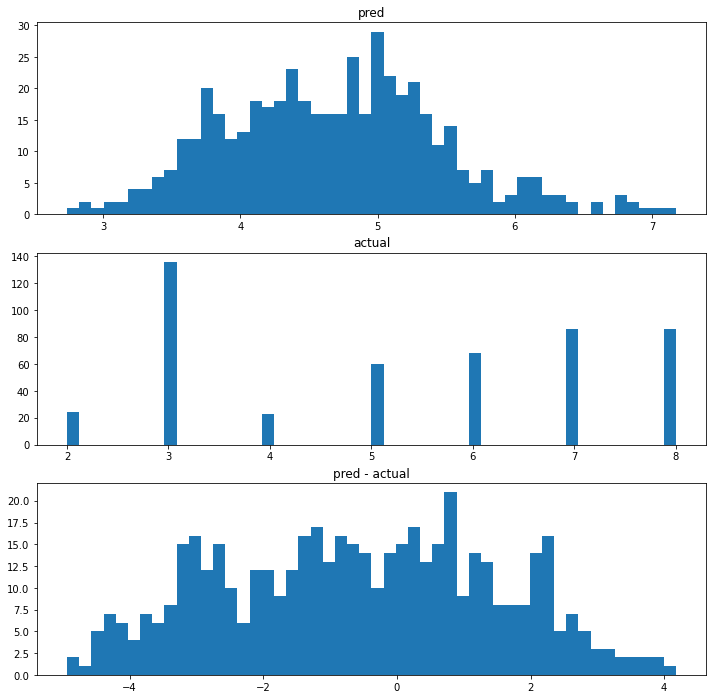

RMSE: 2.111058


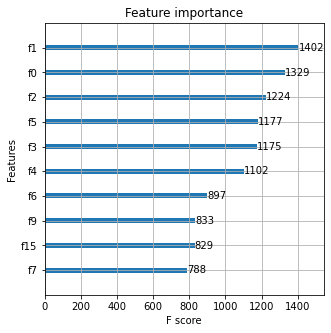

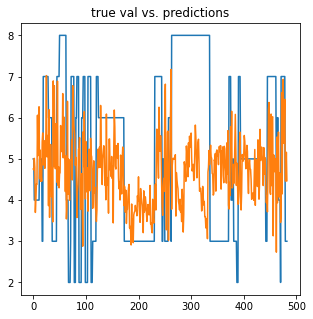

In [8]:
model_emotion_tired = XGBRegressorForSurveyFast(train, test, "tired")

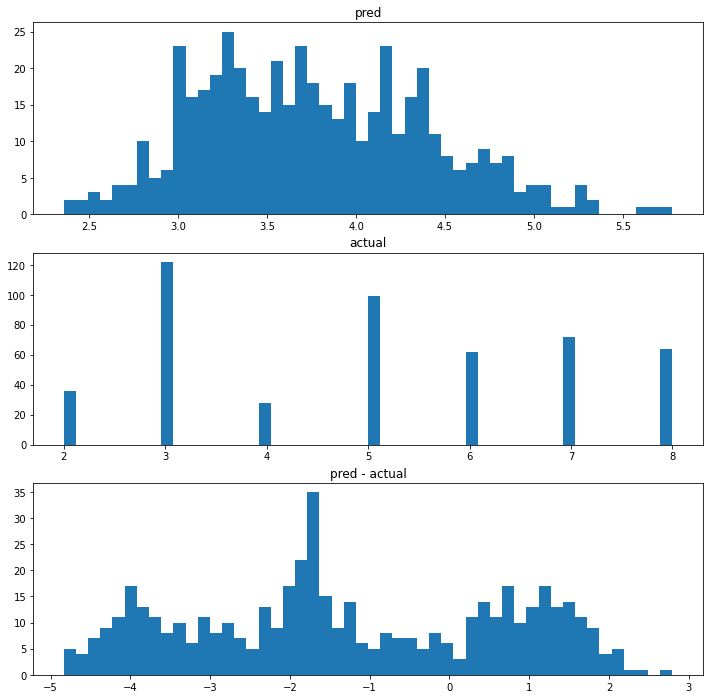

RMSE: 2.322660


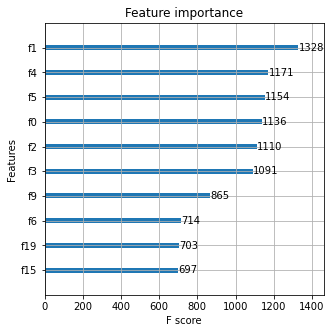

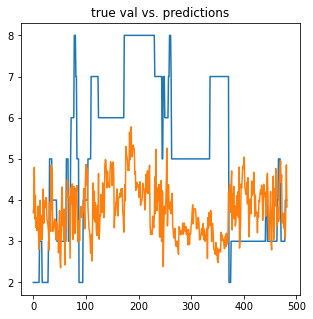

In [9]:
model_emotion_anxious = XGBRegressorForSurveyFast(train, test, "anxious")

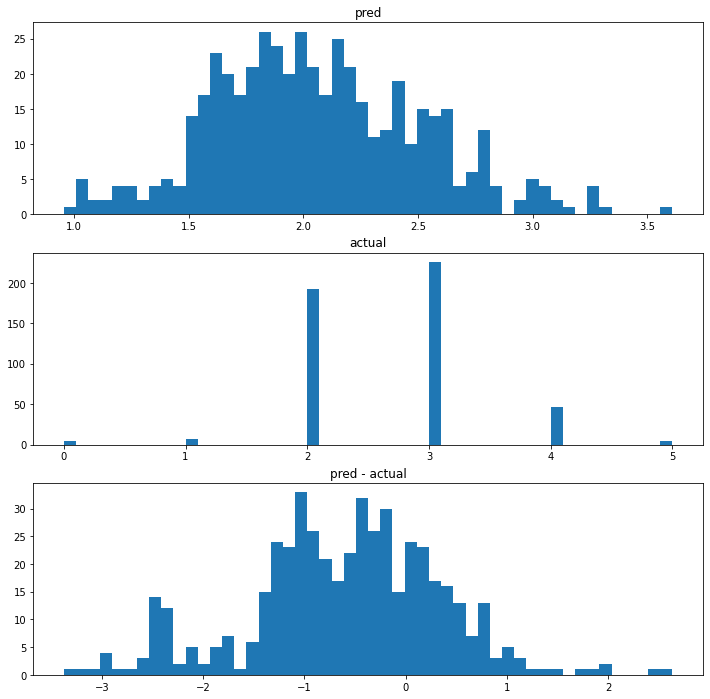

RMSE: 1.119925


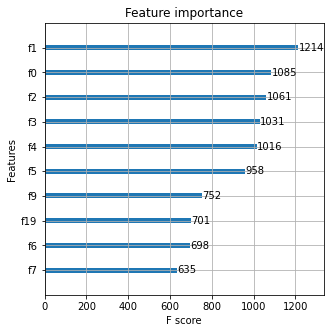

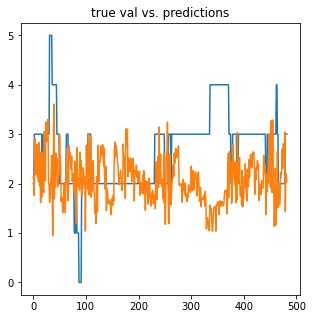

In [10]:
model_emotion_sad = XGBRegressorForSurveyFast(train, test, "sad")

In [11]:
## add train and test with predicted emotions
train_new = df_with_emotion(train, model_emotion_stressed, "stressed")
test_new = df_with_emotion(test, model_emotion_stressed, "stressed")
train_new.head()

,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,craving_onset,acc_x_1min__std,acc_x_1min__mxdiff,...,heartrate_1h__mean,heartrate_1h__std,heartrate_1h__agg_linear_trend,conductance_1h__mean,conductance_1h__std,temperature_1h__mean,temperature_1h__std,bvp_1h__mean,bvp_1h__std,pred_stressed
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-28 23:04:15.156250,-48.0,-6.0,26.0,55.300000,0.157604,90.82,33.79,False,13.081328,78.0,...,91.867970,11.359312,4.309597e-12,0.095627,0.054614,32.172899,1.270200,-0.861997,206.661256,6.999888
2020-01-29 01:01:44.812500,26.0,-47.0,40.0,-15.215000,0.098662,90.10,33.55,False,27.420038,140.0,...,90.965239,14.418683,-5.128420e-12,0.363893,0.469538,33.290916,0.689375,-0.344599,193.783685,6.999276
2020-01-29 01:39:24.312500,-3.0,-63.0,7.0,-14.425000,0.023064,113.83,21.59,False,0.091073,2.0,...,93.093613,17.364942,1.522345e-11,0.171264,0.240193,30.684469,4.935246,-1.583329,197.336529,7.000092
2020-01-29 01:58:46.500000,-3.0,-63.0,7.0,0.643333,0.016657,101.10,17.96,False,0.050965,1.0,...,98.152449,20.336729,1.423379e-11,0.068867,0.054132,27.716593,6.735566,-1.368394,172.377745,6.999632
2020-01-29 04:28:55.406250,28.0,-32.0,46.0,-80.275000,2.544516,90.07,32.47,False,13.916888,38.0,...,91.935973,10.617933,7.414594e-12,0.319129,0.538394,32.386633,0.361547,-0.164057,138.679206,7.000198


In [12]:
train_new_1 = df_with_emotion(train_new, model_emotion_anxious, "anxious")
test_new_1 = df_with_emotion(test_new, model_emotion_anxious, "anxious")
train_new_1.head()

,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,craving_onset,acc_x_1min__std,acc_x_1min__mxdiff,...,heartrate_1h__std,heartrate_1h__agg_linear_trend,conductance_1h__mean,conductance_1h__std,temperature_1h__mean,temperature_1h__std,bvp_1h__mean,bvp_1h__std,pred_stressed,pred_anxious
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-28 23:04:15.156250,-48.0,-6.0,26.0,55.300000,0.157604,90.82,33.79,False,13.081328,78.0,...,11.359312,4.309597e-12,0.095627,0.054614,32.172899,1.270200,-0.861997,206.661256,6.999888,6.999298
2020-01-29 01:01:44.812500,26.0,-47.0,40.0,-15.215000,0.098662,90.10,33.55,False,27.420038,140.0,...,14.418683,-5.128420e-12,0.363893,0.469538,33.290916,0.689375,-0.344599,193.783685,6.999276,6.999049
2020-01-29 01:39:24.312500,-3.0,-63.0,7.0,-14.425000,0.023064,113.83,21.59,False,0.091073,2.0,...,17.364942,1.522345e-11,0.171264,0.240193,30.684469,4.935246,-1.583329,197.336529,7.000092,7.000030
2020-01-29 01:58:46.500000,-3.0,-63.0,7.0,0.643333,0.016657,101.10,17.96,False,0.050965,1.0,...,20.336729,1.423379e-11,0.068867,0.054132,27.716593,6.735566,-1.368394,172.377745,6.999632,7.000234
2020-01-29 04:28:55.406250,28.0,-32.0,46.0,-80.275000,2.544516,90.07,32.47,False,13.916888,38.0,...,10.617933,7.414594e-12,0.319129,0.538394,32.386633,0.361547,-0.164057,138.679206,7.000198,7.000025


In [13]:
train_new_1.head()

,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,craving_onset,acc_x_1min__std,acc_x_1min__mxdiff,...,heartrate_1h__std,heartrate_1h__agg_linear_trend,conductance_1h__mean,conductance_1h__std,temperature_1h__mean,temperature_1h__std,bvp_1h__mean,bvp_1h__std,pred_stressed,pred_anxious
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-28 23:04:15.156250,-48.0,-6.0,26.0,55.300000,0.157604,90.82,33.79,False,13.081328,78.0,...,11.359312,4.309597e-12,0.095627,0.054614,32.172899,1.270200,-0.861997,206.661256,6.999888,6.999298
2020-01-29 01:01:44.812500,26.0,-47.0,40.0,-15.215000,0.098662,90.10,33.55,False,27.420038,140.0,...,14.418683,-5.128420e-12,0.363893,0.469538,33.290916,0.689375,-0.344599,193.783685,6.999276,6.999049
2020-01-29 01:39:24.312500,-3.0,-63.0,7.0,-14.425000,0.023064,113.83,21.59,False,0.091073,2.0,...,17.364942,1.522345e-11,0.171264,0.240193,30.684469,4.935246,-1.583329,197.336529,7.000092,7.000030
2020-01-29 01:58:46.500000,-3.0,-63.0,7.0,0.643333,0.016657,101.10,17.96,False,0.050965,1.0,...,20.336729,1.423379e-11,0.068867,0.054132,27.716593,6.735566,-1.368394,172.377745,6.999632,7.000234
2020-01-29 04:28:55.406250,28.0,-32.0,46.0,-80.275000,2.544516,90.07,32.47,False,13.916888,38.0,...,10.617933,7.414594e-12,0.319129,0.538394,32.386633,0.361547,-0.164057,138.679206,7.000198,7.000025


In [14]:
train_new_2 = df_with_emotion(train_new_1, model_emotion_happy, "happy")
test_new_2 = df_with_emotion(test_new_1, model_emotion_happy, "happy")
train_new_2.head(5)

,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,craving_onset,acc_x_1min__std,acc_x_1min__mxdiff,...,heartrate_1h__agg_linear_trend,conductance_1h__mean,conductance_1h__std,temperature_1h__mean,temperature_1h__std,bvp_1h__mean,bvp_1h__std,pred_stressed,pred_anxious,pred_happy
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-28 23:04:15.156250,-48.0,-6.0,26.0,55.300000,0.157604,90.82,33.79,False,13.081328,78.0,...,4.309597e-12,0.095627,0.054614,32.172899,1.270200,-0.861997,206.661256,6.999888,6.999298,6.000176
2020-01-29 01:01:44.812500,26.0,-47.0,40.0,-15.215000,0.098662,90.10,33.55,False,27.420038,140.0,...,-5.128420e-12,0.363893,0.469538,33.290916,0.689375,-0.344599,193.783685,6.999276,6.999049,5.999959
2020-01-29 01:39:24.312500,-3.0,-63.0,7.0,-14.425000,0.023064,113.83,21.59,False,0.091073,2.0,...,1.522345e-11,0.171264,0.240193,30.684469,4.935246,-1.583329,197.336529,7.000092,7.000030,6.000181
2020-01-29 01:58:46.500000,-3.0,-63.0,7.0,0.643333,0.016657,101.10,17.96,False,0.050965,1.0,...,1.423379e-11,0.068867,0.054132,27.716593,6.735566,-1.368394,172.377745,6.999632,7.000234,6.000088
2020-01-29 04:28:55.406250,28.0,-32.0,46.0,-80.275000,2.544516,90.07,32.47,False,13.916888,38.0,...,7.414594e-12,0.319129,0.538394,32.386633,0.361547,-0.164057,138.679206,7.000198,7.000025,6.000432


In [15]:
train_new_3 = df_with_emotion(train_new_2, model_emotion_relaxed, "relaxed")
test_new_3 = df_with_emotion(test_new_2, model_emotion_relaxed, "relaxed")
train_new_3.head(5)

,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,craving_onset,acc_x_1min__std,acc_x_1min__mxdiff,...,conductance_1h__mean,conductance_1h__std,temperature_1h__mean,temperature_1h__std,bvp_1h__mean,bvp_1h__std,pred_stressed,pred_anxious,pred_happy,pred_relaxed
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-28 23:04:15.156250,-48.0,-6.0,26.0,55.300000,0.157604,90.82,33.79,False,13.081328,78.0,...,0.095627,0.054614,32.172899,1.270200,-0.861997,206.661256,6.999888,6.999298,6.000176,5.999979
2020-01-29 01:01:44.812500,26.0,-47.0,40.0,-15.215000,0.098662,90.10,33.55,False,27.420038,140.0,...,0.363893,0.469538,33.290916,0.689375,-0.344599,193.783685,6.999276,6.999049,5.999959,5.998761
2020-01-29 01:39:24.312500,-3.0,-63.0,7.0,-14.425000,0.023064,113.83,21.59,False,0.091073,2.0,...,0.171264,0.240193,30.684469,4.935246,-1.583329,197.336529,7.000092,7.000030,6.000181,6.000221
2020-01-29 01:58:46.500000,-3.0,-63.0,7.0,0.643333,0.016657,101.10,17.96,False,0.050965,1.0,...,0.068867,0.054132,27.716593,6.735566,-1.368394,172.377745,6.999632,7.000234,6.000088,5.999433
2020-01-29 04:28:55.406250,28.0,-32.0,46.0,-80.275000,2.544516,90.07,32.47,False,13.916888,38.0,...,0.319129,0.538394,32.386633,0.361547,-0.164057,138.679206,7.000198,7.000025,6.000432,5.999627


In [16]:
train_new_4 = df_with_emotion(train_new_3, model_emotion_relaxed, "sad")
test_new_4 = df_with_emotion(test_new_3, model_emotion_relaxed, "sad")
train_new_4.head(5)

,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,craving_onset,acc_x_1min__std,acc_x_1min__mxdiff,...,conductance_1h__std,temperature_1h__mean,temperature_1h__std,bvp_1h__mean,bvp_1h__std,pred_stressed,pred_anxious,pred_happy,pred_relaxed,pred_sad
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-28 23:04:15.156250,-48.0,-6.0,26.0,55.300000,0.157604,90.82,33.79,False,13.081328,78.0,...,0.054614,32.172899,1.270200,-0.861997,206.661256,6.999888,6.999298,6.000176,5.999979,5.999979
2020-01-29 01:01:44.812500,26.0,-47.0,40.0,-15.215000,0.098662,90.10,33.55,False,27.420038,140.0,...,0.469538,33.290916,0.689375,-0.344599,193.783685,6.999276,6.999049,5.999959,5.998761,5.998761
2020-01-29 01:39:24.312500,-3.0,-63.0,7.0,-14.425000,0.023064,113.83,21.59,False,0.091073,2.0,...,0.240193,30.684469,4.935246,-1.583329,197.336529,7.000092,7.000030,6.000181,6.000221,6.000221
2020-01-29 01:58:46.500000,-3.0,-63.0,7.0,0.643333,0.016657,101.10,17.96,False,0.050965,1.0,...,0.054132,27.716593,6.735566,-1.368394,172.377745,6.999632,7.000234,6.000088,5.999433,5.999433
2020-01-29 04:28:55.406250,28.0,-32.0,46.0,-80.275000,2.544516,90.07,32.47,False,13.916888,38.0,...,0.538394,32.386633,0.361547,-0.164057,138.679206,7.000198,7.000025,6.000432,5.999627,5.999627


In [17]:
train_new_5 = df_with_emotion(train_new_4, model_emotion_relaxed, "tired")
test_new_5 = df_with_emotion(test_new_4, model_emotion_relaxed, "tired")
train_new_5.head(5)

,acc_x,acc_y,acc_z,bvp,conductance,heartrate,temperature,craving_onset,acc_x_1min__std,acc_x_1min__mxdiff,...,temperature_1h__mean,temperature_1h__std,bvp_1h__mean,bvp_1h__std,pred_stressed,pred_anxious,pred_happy,pred_relaxed,pred_sad,pred_tired
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-28 23:04:15.156250,-48.0,-6.0,26.0,55.300000,0.157604,90.82,33.79,False,13.081328,78.0,...,32.172899,1.270200,-0.861997,206.661256,6.999888,6.999298,6.000176,5.999979,5.999979,5.999979
2020-01-29 01:01:44.812500,26.0,-47.0,40.0,-15.215000,0.098662,90.10,33.55,False,27.420038,140.0,...,33.290916,0.689375,-0.344599,193.783685,6.999276,6.999049,5.999959,5.998761,5.998761,5.998761
2020-01-29 01:39:24.312500,-3.0,-63.0,7.0,-14.425000,0.023064,113.83,21.59,False,0.091073,2.0,...,30.684469,4.935246,-1.583329,197.336529,7.000092,7.000030,6.000181,6.000221,6.000221,6.000221
2020-01-29 01:58:46.500000,-3.0,-63.0,7.0,0.643333,0.016657,101.10,17.96,False,0.050965,1.0,...,27.716593,6.735566,-1.368394,172.377745,6.999632,7.000234,6.000088,5.999433,5.999433,5.999433
2020-01-29 04:28:55.406250,28.0,-32.0,46.0,-80.275000,2.544516,90.07,32.47,False,13.916888,38.0,...,32.386633,0.361547,-0.164057,138.679206,7.000198,7.000025,6.000432,5.999627,5.999627,5.999627


## prediction on craving_onset

In [18]:
model = training_to_xgb(train_new_5)

/Users/yangtian/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:45:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [19]:
preds = test_xgb(test_new_5, model)

Accuracy: 51.76%
Precision: 59.44%
[[219  14]
 [219  31]]


In [20]:
## Print feature importance
importance = model.feature_importances_
names = train_new_5.columns
found_index = np.in1d(names, 'craving_onset').nonzero()[0]
names = np.delete(names, found_index)
dataset = pd.DataFrame({'importance': importance, 'names': list(names)}, columns=['importance', 'names'])
dataset.sort_values(by=['importance'], inplace=True, ascending=False)
dataset.head(15)

,importance,names
37,0.075369,pred_stressed
28,0.049915,heartrate_1h__mean
33,0.043826,temperature_1h__mean
36,0.042059,bvp_1h__std
25,0.037242,acc_y_1h__mxdiff
32,0.036476,conductance_1h__std
38,0.035914,pred_anxious
40,0.034672,pred_relaxed
16,0.034659,conductance_1min__mean
34,0.031161,temperature_1h__std


In [47]:
model = classify(train_new_5, test_new_5)

/Users/yangtian/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6392679900744417 0.5652173913043478
[[213  20]
 [190  60]]


In [48]:
## Print feature importance
importance = model.feature_importances_
names = train_new_5.columns
found_index = np.in1d(names, 'craving_onset').nonzero()[0]
names = np.delete(names, found_index)
dataset = pd.DataFrame({'importance': importance, 'names': list(names)}, columns=['importance', 'names'])
dataset.sort_values(by=['importance'], inplace=True, ascending=False)
dataset.head(15)

,importance,names
37,0.059013,pred_stressed
28,0.055583,heartrate_1h__mean
34,0.049088,temperature_1h__std
6,0.040477,temperature
23,0.034411,acc_x_1h__mxdiff
33,0.033561,temperature_1h__mean
39,0.033152,pred_happy
41,0.032871,pred_sad
29,0.031260,heartrate_1h__std
9,0.030194,acc_y_1min__std


## try to use the first 80% as trainning and last 20% as testing

In [63]:
total_df = pd.concat([train_new, test_new])
train_point = int(round(0.80*len(total_df)))
train_total = total_df.iloc[:train_point]
test_total = total_df.iloc[train_point:]

In [64]:
model = classify(train_total, test_total)

/Users/yangtian/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5352250489236791 0.3756476683937824
[[130   6]
 [235  15]]


In [65]:
## Print feature importance
importance = model.feature_importances_
names = train_new.columns
found_index = np.in1d(names, 'craving_onset').nonzero()[0]
names = np.delete(names, found_index)
dataset = pd.DataFrame({'importance': importance, 'names': list(names)}, columns=['importance', 'names'])
dataset.sort_values(by=['importance'], inplace=True, ascending=False)
dataset.head(10)

,importance,names
34,0.062883,temperature_1h__std
37,0.054389,pred_stressed
38,0.044657,pred_anxious
31,0.041717,conductance_1h__mean
25,0.039759,acc_y_1h__mxdiff
26,0.038665,acc_z_1h__std
33,0.037663,temperature_1h__mean
13,0.037663,heartrate_1min__mean
23,0.036163,acc_x_1h__mxdiff
36,0.035154,bvp_1h__std


In [30]:
train = pd.concat([df1, df2, df3])
test = prepare_data_resample(89, 4)
model1 = classify(train, test)

0.5156762940610804 0.837037037037037
[[560 101]
 [  9   5]]


/Users/yangtian/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [32]:
## Print feature importance
importance = model1.feature_importances_
names = train.columns
found_index = np.in1d(names, 'craving_onset').nonzero()[0]
names = np.delete(names, found_index)
dataset = pd.DataFrame({'importance': importance, 'names': list(names)}, columns=['importance', 'names'])
dataset.sort_values(by=['importance'], inplace=True, ascending=False)
dataset.head(15)

,importance,names
24,0.081209,tired
22,0.060449,happy
6,0.052321,temperature_raw
26,0.051146,sad
4,0.050791,conductance_raw
0,0.048475,acc_x_raw
18,0.047373,conductance_std
12,0.043176,heartrate_mean
9,0.041708,acc_z_mean
20,0.040081,temperature_std


In [60]:
len(names)

43